<a href="https://colab.research.google.com/github/apmoore1/tdsa_comparisons/blob/master/analysis/Position_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
all_results = pd.read_csv('https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/main/results.tsv', sep='\t')
all_results = all_results.drop(columns=['index', 'Unnamed: 0'])
all_results = all_results.replace({'Model': 'AE'}, 'Att-AE')

In [ ]:
from typing import Dict, Any, List, Tuple, Callable

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from target_extraction.analysis.util import long_format_metrics, metric_p_values

from typing import Optional, Callable, Union, List, Dict, Any, Tuple
def create_p_value_heatmap(df: pd.DataFrame, value_column: str, 
                           pivot_columns: List[str], pivot_indexes: List[str],
                           x_label: str, y_label: str,
                           pivot_table_agg_func: Optional[Callable[[pd.Series], Any]] = None,
                           cubehelix_palette_kwargs: Optional[Dict[str, Any]] = None,
                           value_range: Optional[List[int]] = None,
                           lines: bool = True, line_color: str = 'k',
                           vertical_lines_index: Optional[List[int]] = None,
                           horizontal_lines_index: Optional[List[int]] = None,
                           ax: Optional[matplotlib.pyplot.Axes] = None,
                           heatmap_kwargs: Optional[Dict[str, Any]] = None,
                           column_order: Optional[List[str]] = None,
                           row_order: Optional[List[str]] = None
                          ) -> matplotlib.pyplot.Axes:
    '''
    :param subset_df: A DataFrame that contains the following columns: 
                      1. Error Split, 2. Error Subset, 3. Dataset, 
                      and 4. `value_column`
    :param value_column: The column that contains the value to be plotted in the 
                         heatmap.
    :param pivot_columns: The name of the columns from the `df` that will be used 
                          to create the columns in the pivot table that creates 
                          the heatmap
    :param pivot_indexes: The name of the columns from the `df` that will be used
                          to create the indexes in the pivot table that creates
                          the heatmap
    :param x_label: The label for the X axis in the created heatmap.
    :param y_label: The label for the Y axis in the created heatmap.
    :param pivot_table_agg_func: As a pivot table is created to create the heatmap.
                                 This allows the replacement default aggregation 
                                 function (np.mean) with a custom function. The 
                                 pivot table aggregates the `value_column` by 
                                 Dataset, Error Split, and Error Subset.
    :param cubehelix_palette_kwargs: Keywords arguments to give to the 
                                     seaborn.cubehelix_palette
                                     https://seaborn.pydata.org/generated/seaborn.cubehelix_palette.html.
                                     Default produces white to dark red.
    :param value_range: This can also be interpreted as the values allowed in 
                        the color range and should cover at least all unique 
                        values in `value_column`.
    :param lines: Whether or not lines should appear on the plot to define the 
                  different error splits.
    :param line_color: Color of the lines if the lines are to be displayed. The 
                       choice of color names can be found here: 
                       https://matplotlib.org/3.1.1/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
    :param vertical_lines_index: The index of the lines in vertical/column 
                                 direction. If None default is [0,3,7,11,15,18]
    :param horizontal_lines_index: The index of the lines in vertical/column 
                                   direction. If None default is [0,1,2,3]
    :param ax: A matplotlib Axes to give to the seaborn function to plot the 
               heatmap on to.
    :param heatmap_kwargs: Keyword arguments to pass to the seaborn.heatmap 
                           function
    :returns: A heatmap where the Y-axis represents the datasets, X-axis 
              represents the Error subsets formatted when appropriate with the 
              Error split name, and the values come from the `value_column`. The 
              heatmap assumes the `value_column` contains discrete values as the 
              color bar is discrete rather than continuos. If you want a continuos 
              color bar it is recommended that you use Seaborn heatmap.
    '''
    df_copy = df.copy(deep=True)
    if pivot_table_agg_func is None:
        pivot_table_agg_func = np.mean
    df_copy = pd.pivot_table(data=df_copy, values=value_column, 
                             columns=pivot_columns, 
                             index=pivot_indexes, aggfunc=pivot_table_agg_func)
    # Remove columns in the column order that do not exist as a column
    if column_order is not None:
      temp_column_order = []
      columns_that_exist = set(df_copy.columns.tolist())
      for column in column_order:
          if column in columns_that_exist:
              temp_column_order.append(column)
      column_order = temp_column_order
      df_copy = df_copy.reindex(column_order, axis=1)
    if row_order is not None:
      temp_row_order = []
      rows_that_exist = set(df_copy.index.tolist())
      for row in row_order:
          if row in rows_that_exist:
              temp_row_order.append(row)
      row_order = temp_row_order
      df_copy = df_copy.reindex(row_order, axis=0)

    unique_values = np.unique(df_copy.values)
    if value_range is not None:
        unique_values = value_range
    num_unique_values = len(unique_values)
    color_bar_spacing = max(unique_values) / num_unique_values
    half_bar_spacing = color_bar_spacing / 2
    colorbar_values = [(i * color_bar_spacing) + half_bar_spacing 
                       for i in range(len(unique_values))]
    if cubehelix_palette_kwargs is None:
        cubehelix_palette_kwargs = {'hue': 1, 'gamma': 2.2, 'light': 1.0, 
                                    'dark': 0.7}
    cmap = sns.cubehelix_palette(n_colors=num_unique_values, 
                                 **cubehelix_palette_kwargs)
    if heatmap_kwargs is None:
        heatmap_kwargs = {}
    vmin = min(unique_values) 
    vmax = max(unique_values)
    if ax is not None:
        ax = sns.heatmap(df_copy, ax=ax, linewidths=.5, linecolor='lightgray', 
                         cmap=matplotlib.colors.ListedColormap(cmap),
                         vmin=vmin, vmax=vmax, **heatmap_kwargs)
    else:
        ax = sns.heatmap(df_copy, linewidths=.5, linecolor='lightgray', 
                         cmap=matplotlib.colors.ListedColormap(cmap),
                         vmin=vmin, vmax=vmax, **heatmap_kwargs)
    cb = ax.collections[-1].colorbar
    cb.set_ticks(colorbar_values)
    cb.set_ticklabels(unique_values)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if lines:
        if vertical_lines_index is None:
            vertical_lines_index = [0,3,7,11,15,18]
        ax.vlines(vertical_lines_index, colors=line_color, *ax.get_ylim())
        if horizontal_lines_index is None:
            horizontal_lines_index = [0,1,2,3]
        ax.hlines(horizontal_lines_index, colors=line_color, *ax.get_xlim())
    return ax

def filter_df(df: pd.DataFrame, column_value: Dict[str, Any]) -> pd.DataFrame:
  filtered_df = df.copy(deep=True)
  for column_name, filter_value in column_value.items():
    filtered_df = filtered_df[filtered_df[f'{column_name}']==filter_value]
  return filtered_df

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def p_value_count(alpha: float) -> Callable[[pd.Series], float]:
  def alpha_count(p_values: pd.Series) -> float:
    significant_p_values = p_values <= alpha
    return int(np.sum(significant_p_values))
  return alpha_count
DATASET_COLUMN_ORDER = ['Election', 'Laptop', 'Restaurant']
ROW_ERROR_SPLIT_ORDER = ['NT', 'DS', 'TSSR', 'n-shot', 'TSR']
SPLIT_ORDER = ['Validation', 'Test']
METRIC_ORDER = ['Macro F1', 'Accuracy', 'STAC 1', 'STAC Multi']

# Position Encoding

In this notebook we explore how position encoding and more specifically position weighting improves TDSA models. The TDSA models used here are:
1. [**IAN**](https://www.ijcai.org/proceedings/2017/0568.pdf)
2. **Att-AE** (We called it *AE* when running the experiments and that is what it is called in the original data) -- A model that is the same as the *AE* model from [Wang et al. 2016](https://www.aclweb.org/anthology/D16-1058.pdf) but with an attention layer after the LSTM enocder. This model is also the same as the inter-aspect model (from now on called **Inter-AE**) from [Hazarika et al. 2018](https://www.aclweb.org/anthology/N18-2043/) but without the LSTM aspect encoder (phase 2 in figure 1) that models other targets from the same context/text.

Of which the position weighting used is that from [Chen et al. 2017]() which weights tokens that are closer to the target higher than those further away, weighting equation can be seen below:

$$w_i = 1 - \frac{|\tau - i|}{n}$$

Where $i$ represents the index of the token/word whose position is to be weighted, $\tau$ represents the index of the closest target token to $i$, and $n$ is the length of the text in tokens.

The position weighting will be applied to the context/sentence vectors after being encoded by the LSTM layer and before the attention is applied in both *IAN* and *Att-AE*.

Before we can move onto any analysis we need to gather all of the relevant data which is done in the code block below:

In [ ]:
# Get the position weighted and the baseline results
position_column_values = {'Inter-Aspect': 'False', 'Position': 'Weighting', 'CWR': False}
overall_position_results = filter_df(all_results, position_column_values)
baseline_column_values = {'Inter-Aspect': 'False', 'Position': 'False', 'CWR': False}
relevant_position_models = ['IAN', 'Att-AE']
overall_baseline_results = filter_df(all_results, baseline_column_values)
overall_baseline_results = overall_baseline_results[overall_baseline_results['Model'].isin(relevant_position_models)]

overall_position_validation_results = overall_position_results[overall_position_results['Data Split']=='Validation']
overall_position_test_results = overall_position_results[overall_position_results['Data Split']=='Test']
plotting_results = long_format_metrics(all_results, ['Accuracy', 'Macro F1', 'STAC Multi', 'STAC 1'])
overall_position_plotting_results = filter_df(plotting_results, position_column_values)
overall_position_plotting_results['Metric Score'] = overall_position_plotting_results['Metric Score'] * 100

overall_baseline_plotting_results = filter_df(plotting_results[plotting_results['Model'].isin(relevant_position_models)], 
                                              baseline_column_values)
overall_baseline_plotting_results['Metric Score'] = overall_baseline_plotting_results['Metric Score'] * 100


## Overall Position Performance
Below we plot the overall performance of the position encoded models:

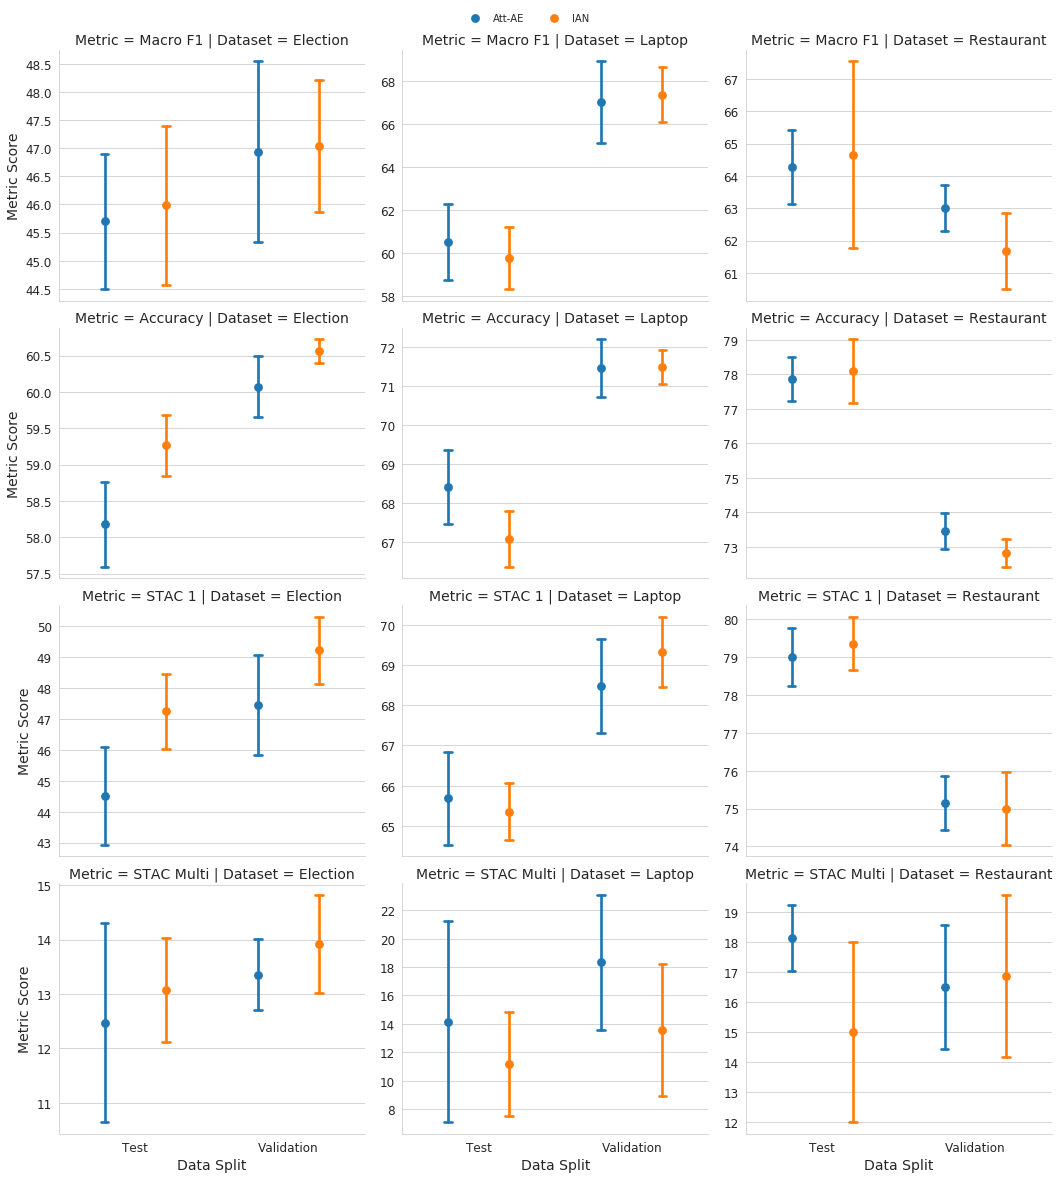

In [ ]:
import seaborn as sns
import matplotlib
matplotlib.rc('font', size=14)
plt.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

cat_plot=sns.catplot(x='Data Split', y='Metric Score',  
                     data=overall_position_plotting_results, 
                     kind='point', col='Dataset', ci='sd', join=False, capsize=.05,
                     hue='Model' ,dodge=0.4, sharey=False, row='Metric', legend=False,
                     col_order=DATASET_COLUMN_ORDER, 
                     row_order=METRIC_ORDER)
cat_plot.fig.set_size_inches(15,16)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=2, 
                        bbox_to_anchor=(0.38, 1))

These scores are somewhat meaningless without comparing them to their respective non-position encoded baseline models. Therefore below we plot the difference between the position and baselines models:

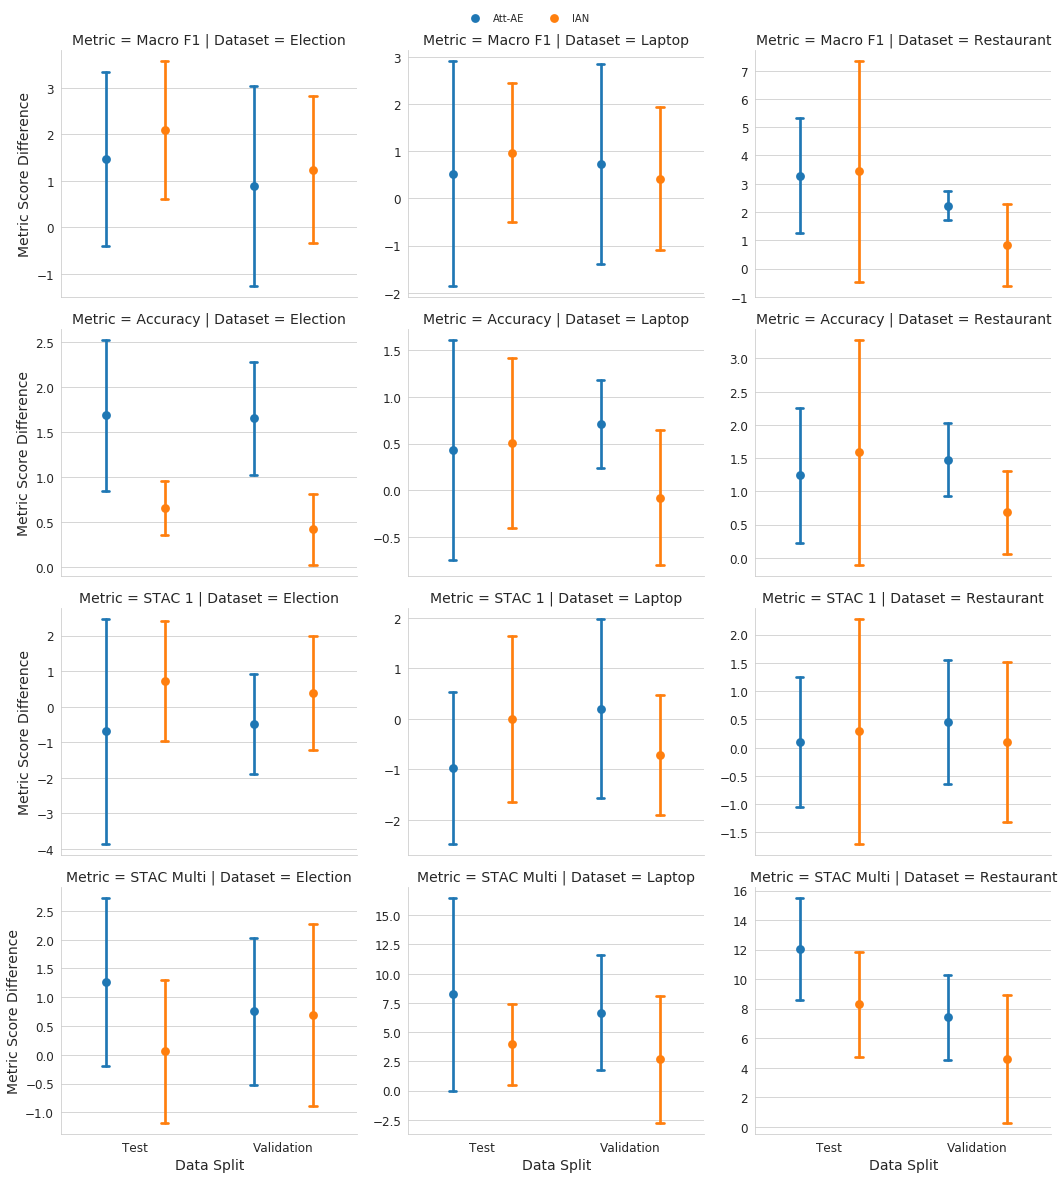

In [ ]:
def compare_results(df_1: pd.DataFrame, df_2: pd.DataFrame, 
                    index_columns: List[str], metric_to_compare: str
                    ) -> pd.DataFrame:
  df_1_copy = df_1.copy(deep=True)
  df_2_copy = df_2.copy(deep=True)
  df_1_copy = df_1_copy.set_index(index_columns)
  df_2_copy = df_2_copy.set_index(index_columns)
  df_1_copy[metric_to_compare] = df_1_copy[metric_to_compare] - df_2_copy[metric_to_compare]
  return df_1_copy.reset_index()

metric_indexs = ['run number', 'Model', 'Dataset', 'Data Split', 'Metric']
difference_position_plotting_results = compare_results(overall_position_plotting_results, 
                                                       overall_baseline_plotting_results, 
                                                       metric_indexs, 'Metric Score')
difference_position_plotting_results['Metric Score Difference'] = difference_position_plotting_results['Metric Score']
cat_plot=sns.catplot(x='Data Split', y='Metric Score Difference',  
                     data=difference_position_plotting_results, 
                     kind='point', col='Dataset', ci='sd', join=False, capsize=.05,
                     hue='Model' ,dodge=0.4, sharey=False, row='Metric', legend=False,
                     col_order=DATASET_COLUMN_ORDER, 
                     row_order=METRIC_ORDER)
cat_plot.fig.set_size_inches(15,16)
_ = cat_plot.add_legend(loc='lower left', borderaxespad=0., ncol=2, 
                        bbox_to_anchor=(0.38, 1))

As we can see from the results the overall trend is that no matter the dataset or metric position weighting on average improves the models performance. There are a few exceptions to this the *STAC 1* results for both Election and Laptop datasets, and the *accuracy* metric for the Laptop dataset. Furthermore there are several results where even though the mean is positive the standard deviations are so large that they go into the negative of the metric score difference. This shows that the trend might show an overall improvement in performance but the improvement is marginal. The Restaurant dataset has the largest improvement overall. Finally the metric that appears to have the largest benefit from position weighting is the *STAC-Multi* which does suggest that position weighting does improve the target sentiment relationship modelling, confirming the hypothesis from the literature about position weighting.

To see if any of these score are statistically significant below we before significance testing. Where we test if the position encoded models are statistically significantly better than the baseline as well as vice versa. In both of these tests we shall uses the one-tailed version as we only want to know if one of the models is better than the other. As the macro F1 is the only metric that we cannot assume is normally distributed we shall use the Wilcox signed-rank test where as for all the other metrics we shall use the Welch's t-test.

In [ ]:
from collections import defaultdict
from target_extraction.analysis.util import create_subset_heatmap, metric_p_values
# Get P-values testing if position encoded models are better than their 
# non-position encoded base model
alpha = 0.05
metric_assumed_normal = [('Accuracy', True), ('STAC 1', True), 
                         ('STAC Multi', True), ('Macro F1', False)]
dataset_names = ['Laptop', 'Restaurant', 'Election']
position_model_names = ['Att-AE-Position', 'IAN-Position']
position_comparison_models = {'Att-AE-Position': 'Att-AE', 'IAN-Position': 'IAN'}
baseline_comparison_models = {'Att-AE': 'Att-AE-Position', 'IAN': 'IAN-Position'}
# Combine both the position and the baseline results so that they can be 
# compared for significance tests.
overall_combined_results = overall_position_results.copy(deep=True)
overall_combined_results['Model']= overall_combined_results['Model'].replace(baseline_comparison_models)
overall_combined_results = pd.concat([overall_combined_results, overall_baseline_results])

overall_p_values = {'Position': [], 'Baseline': []}
split_names = ['Test', 'Validation']
for comparison_name, p_value_list in overall_p_values.items():
  for split_name in split_names:
    split_df = overall_combined_results[overall_combined_results['Data Split']==split_name]
    for position_model_name in position_model_names:
      base_model_name = position_comparison_models[position_model_name]
      if comparison_name == 'Baseline':
        p_value_df = metric_p_values(split_df, f'{position_model_name}', 
                                    [base_model_name], dataset_names, 
                                    metric_assumed_normal)
      else:
        p_value_df = metric_p_values(split_df, base_model_name, 
                                     [f'{position_model_name}'], dataset_names, 
                                     metric_assumed_normal)
      p_value_df['Split'] = split_name
      p_value_list.append(p_value_df)
overall_p_values = {comparison_name: pd.concat(p_value_list, sort=False, ignore_index=True) 
                    for comparison_name, p_value_list in overall_p_values.items()}

/home/andrew/Envs/target_extraction/lib/python3.6/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


The raw P-Values for comparing the position to the associated baseline models are below for each metric, dataset, and split can be seen below.

In [ ]:
pd.pivot_table(data=overall_p_values['Baseline'], values='P-Value', columns=['Better Model'], 
               index=['Metric', 'Dataset','Split'])

Better Model                      Att-AE-Position  IAN-Position
Metric     Dataset    Split                                    
Accuracy   Election   Test               0.000212      0.003690
                      Validation         0.000001      0.014816
           Laptop     Test               0.246149      0.076849
                      Validation         0.048852      0.600986
           Restaurant Test               0.001015      0.017175
                      Validation         0.000029      0.011100
Macro F1   Election   Test               0.061743      0.012531
                      Validation         0.200407      0.061743
           Laptop     Test               0.287702      0.061743
                      Validation         0.241920      0.163495
           Restaurant Test               0.005859      0.046446
                      Validation         0.005859      0.080715
STAC 1     Election   Test               0.732430      0.122952
                      Validation         0.734250      0.290137
           Laptop     Test               0.889991      0.500000
                      Validation         0.386480      0.934501
           Restaurant Test               0.404576      0.362367
                      Validation         0.227050      0.417809
STAC Multi Election   Test               0.071740      0.452553
                      Validation         0.112121      0.114660
           Laptop     Test               0.010539      0.021230
                      Validation         0.004166      0.132513
           Restaurant Test               0.000002      0.001153
                      Validation         0.000008      0.001537

The raw P-Values for comparing the baseline models to their associated position models:

In [ ]:
pd.pivot_table(data=overall_p_values['Position'], values='P-Value', columns=['Better Model'], 
               index=['Metric', 'Dataset', 'Split'])

Better Model                        Att-AE       IAN
Metric     Dataset    Split                         
Accuracy   Election   Test        0.999788  0.996310
                      Validation  0.999999  0.985184
           Laptop     Test        0.753851  0.923151
                      Validation  0.951148  0.399014
           Restaurant Test        0.998985  0.982825
                      Validation  0.999971  0.988900
Macro F1   Election   Test        0.938257  0.987469
                      Validation  0.799593  0.938257
           Laptop     Test        0.712298  0.938257
                      Validation  0.758080  0.836505
           Restaurant Test        0.994141  0.953554
                      Validation  0.994141  0.919285
STAC 1     Election   Test        0.267570  0.877048
                      Validation  0.265750  0.709863
           Laptop     Test        0.110009  0.500000
                      Validation  0.613520  0.065499
           Restaurant Test        0.595424  0.637633
                      Validation  0.772950  0.582191
STAC Multi Election   Test        0.928260  0.547447
                      Validation  0.887879  0.885340
           Laptop     Test        0.989461  0.978770
                      Validation  0.995834  0.867487
           Restaurant Test        0.999998  0.998847
                      Validation  0.999992  0.998463

To better visulise the P-Values from above, below we create heatmaps showing the number of models that are significantly better:

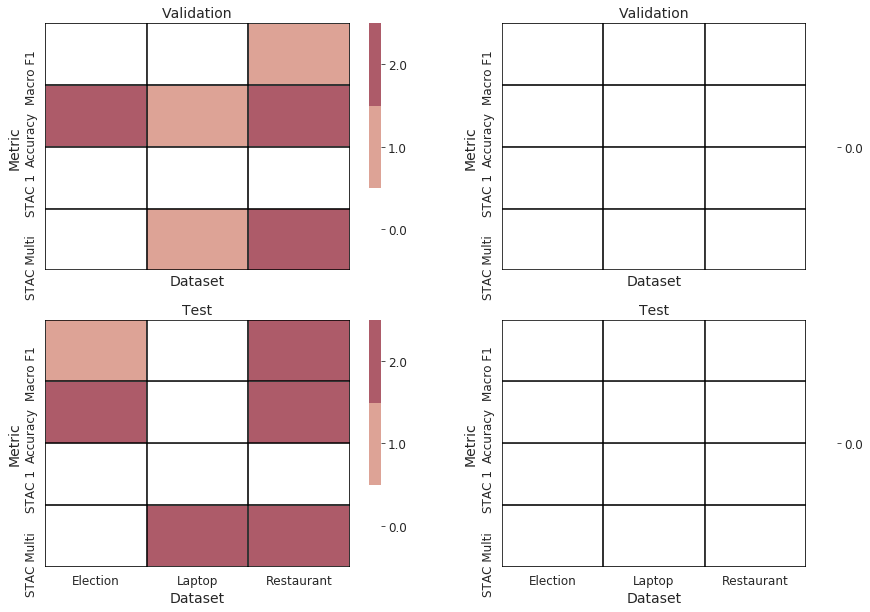

In [ ]:
v_lines = [0,1,2,3]
h_lines = [0,1,2,3,4,5]
h_map_kwargs = {'value_column': 'P-Value', 'pivot_columns': ['Dataset'], 
                'pivot_indexes': ['Metric'], 'x_label': 'Dataset', 
                'y_label': 'Metric', 'pivot_table_agg_func': p_value_count(0.05),
                'vertical_lines_index': v_lines, 
                'horizontal_lines_index': h_lines}
h_map_fig, h_map_axes = plt.subplots(2,2, figsize=(15,10), sharex=True)
for column_index, comparison_name in enumerate(['Baseline', 'Position']):
  p_value_df = overall_p_values[comparison_name]
  validation_p_values = p_value_df[p_value_df['Split']=='Validation']
  test_p_values = p_value_df[p_value_df['Split']=='Test']
  h_map_axes[0][column_index] = create_p_value_heatmap(validation_p_values, **h_map_kwargs, 
                                                       row_order=METRIC_ORDER,
                                                       column_order=DATASET_COLUMN_ORDER,
                                                       ax=h_map_axes[0][column_index])
  h_map_axes[0][column_index].set_title('Validation')
  h_map_axes[1][column_index] = create_p_value_heatmap(test_p_values, **h_map_kwargs, 
                                                       row_order=METRIC_ORDER,
                                                       column_order=DATASET_COLUMN_ORDER,
                                                       ax=h_map_axes[1][column_index])
  _ = h_map_axes[1][column_index].set_title('Test')

The first column of heatmaps show the number of Position models that are statistically significantly better than their associated non-position (baseline) equivalents. The second column shows the vice versa (the number of baseline models better than the their position alternatives). As we can see none of the baseline models are better than their position alternatives on any of the metrics. Therefore below we only show the heatmps for the first column:

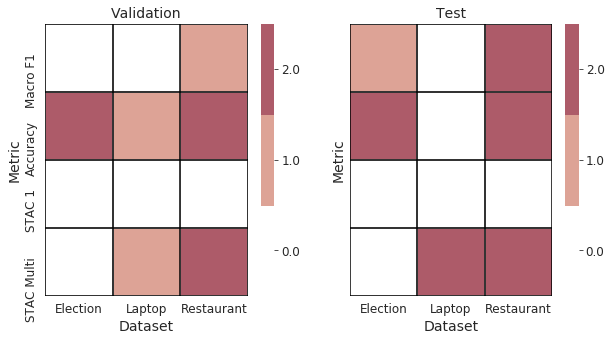

In [ ]:
h_map_fig, h_map_axes = plt.subplots(1,2, figsize=(10,5), sharey=True)
p_value_df = overall_p_values['Baseline']
validation_p_values = p_value_df[p_value_df['Split']=='Validation']
test_p_values = p_value_df[p_value_df['Split']=='Test']
h_map_axes[0] = create_p_value_heatmap(validation_p_values, **h_map_kwargs, 
                                       row_order=METRIC_ORDER,
                                       column_order=DATASET_COLUMN_ORDER,
                                       ax=h_map_axes[0])
h_map_axes[0].set_title('Validation')
h_map_axes[1] = create_p_value_heatmap(test_p_values, **h_map_kwargs,
                                       row_order=METRIC_ORDER,
                                       column_order=DATASET_COLUMN_ORDER, 
                                       ax=h_map_axes[1])
_ = h_map_axes[1].set_title('Test')

To further ensure empirical rigour below we plot the number of position models that are statistically significantly better than their baseline across all datasets correcting the multiple hypothesis tests using Bonferroni. As we are correcting for the multiple test we can see that the number of models that were significant on their own dataset for the *STAC Multi* metric goes from 4 to 3 after correcting on the test split. Confidence level is set at 95%. The number of possible models that can be significant for each metric is 6 as there are 2 models and 3 dataset thus 6 different possible models to compare the position version with the baseline.

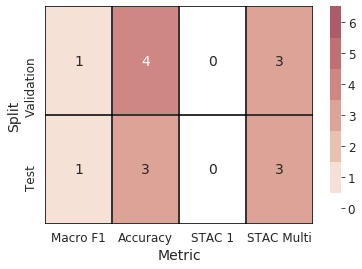

In [ ]:
from target_extraction.analysis.statistical_analysis import find_k_estimator
corrected_split_names = []
corrected_sig_models = []
corrected_metrics = []
for split_name in split_names:
  p_value_df = overall_p_values['Baseline']
  split_df = p_value_df[p_value_df['Split']==split_name]
  metrics = split_df['Metric'].unique().tolist()
  for metric in metrics:
    metric_df = split_df[split_df['Metric']==metric]
    num_sig_models = find_k_estimator(metric_df['P-Value'], 
                                      alpha=0.05, method='B')
    corrected_metrics.append(metric)
    corrected_sig_models.append(num_sig_models)
    corrected_split_names.append(split_name)
corrected_p_values_df = pd.DataFrame({'Num Sig Models': corrected_sig_models, 
                                      'Metrics': corrected_metrics, 
                                      'Split': corrected_split_names})
h_map_sig_kwargs = {'value_column': 'Num Sig Models', 'pivot_columns': ['Metrics'], 
                    'pivot_indexes': ['Split'], 'x_label': 'Metric', 
                    'y_label': 'Split', 'pivot_table_agg_func': np.sum,
                    'vertical_lines_index': [0,1,2,3,4,5,6], 
                    'horizontal_lines_index': [0,1,2]}
heatmap_kwargs = {'annot': True}
_ = create_p_value_heatmap(corrected_p_values_df, **h_map_sig_kwargs, 
                           column_order=METRIC_ORDER,
                           row_order = SPLIT_ORDER,
                           value_range=range(7),heatmap_kwargs=heatmap_kwargs)

As we can see from above the Laptop and the Restaurant datasets are the only datasets that consistently have posiiton models that are significantly better on the *STAC Multi* metric. Furthermore the Laptop dataset is the only datasets that does not find the Position models to be consistently significantly better than the baselines for the Accuracy. This might not be a surprsing finding considering that the Laptop dataset contains the least number of $DS_2$ and $DS_3$ samples relative to it's size. Thus as the findings suggest here that the position information improves the scores on the samples that have multiple unique sentiments within the sentences ($DS_2$ and $DS_3$). Then for a dataset that is made up of mainly sentence that only contain one unique sentiment, position information cannot massively improve the overall results. Hence the potential reason why the accuracy results find no significant improvement from using position information on the Laptop dataset. This reason is also realted to another potential hypothesis on why position information does not help the *STAC 1* metric singificantly. As the *STAC 1* metric is only looking at the accuracy score for sentences that contain one unique sentiment and that the model predicts are samples in that sentence correctly. A model that overfits to the most frequent sentiment class will perform well on this metric. As the position information is biasing the model towards only looking at local context around the target it removes the bias for the model to look at the global context. Therefore removes to some extent the models capability to exploit the overall sentiment of the sentence and thus the sentiment overfitting. It is clear to some degree that for at least the Laptop and Restaurant datasets that as the position models have improved on the *STAC Multi* metric and not regressed on the *STAC 1* metric, that the models are less prone to sentiment overfitting and do perform better at target sentiment relation modelling. Thus confirming the hypothesis from the literature.


From the results we can see that the Election dataset is the only one that the models do not perform significantly better than the baseline version on the *STAC Multi* metric. However they do consistently perform better on the Accuracy metric. This may suggest that the position information does improve the target sentiment relationship modelling but cannot be shown through the *STAC Multi* metric as it requires all targets in the sentence to be correctly classified. The further reason why it is believed that it is improving the target sentiment relationship modelling rather than overfitting to the overall sentiment as the *STAC 1* metric has not improved on the dataset. To investigate this further we shall plot below the *DS* and *TSR* split results: 

In [ ]:
# Get the position weighted and the baseline plotting results
import copy
from target_extraction.analysis.sentiment_error_analysis import ERROR_SPLIT_SUBSET_NAMES
from target_extraction.analysis.sentiment_error_analysis import subset_name_to_error_split
from target_extraction.analysis.sentiment_error_analysis import PLOT_SUBSET_ABBREVIATION
subset_names = []
subset_names = copy.deepcopy(ERROR_SPLIT_SUBSET_NAMES['DS'])
subset_names.extend(ERROR_SPLIT_SUBSET_NAMES['TSR'])
subset_names.extend(ERROR_SPLIT_SUBSET_NAMES['NT'])

subset_plotting_results = long_format_metrics(all_results, subset_names)
subset_plotting_results = subset_plotting_results[subset_plotting_results['Model'].isin(relevant_position_models)]
subset_plotting_results['Error Split'] = subset_plotting_results.apply(lambda x: subset_name_to_error_split(x['Metric']), 1)
subset_plotting_results['Accuracy'] = subset_plotting_results['Metric Score'] * 100
subset_plotting_results = subset_plotting_results.rename(columns={'Metric': 'Error Subset'})
subset_plotting_results['Error Subset'] = subset_plotting_results.apply(lambda x: PLOT_SUBSET_ABBREVIATION[x['Error Subset']], 1)
# Drop the DS3 results for the Laptop and Restaurant datasets
laptop_ds3_filter = (subset_plotting_results['Dataset']=='Laptop') & (subset_plotting_results['Error Subset']=='DS3')
restaurant_ds3_filter = (subset_plotting_results['Dataset']=='Restaurant') & (subset_plotting_results['Error Subset']=='DS3')
subset_plotting_results = subset_plotting_results[~(laptop_ds3_filter | restaurant_ds3_filter)]

subset_position_plotting_results = filter_df(subset_plotting_results, position_column_values)
subset_position_plotting_validation_results = subset_position_plotting_results[subset_position_plotting_results['Data Split']=='Validation']
subset_position_plotting_test_results = subset_position_plotting_results[subset_position_plotting_results['Data Split']=='Test']

Below we have show the *DS* and *TSR* results for both the Validation and Test results where the second set of results show the performance difference between the Position and their respective baseline models:

Validation:

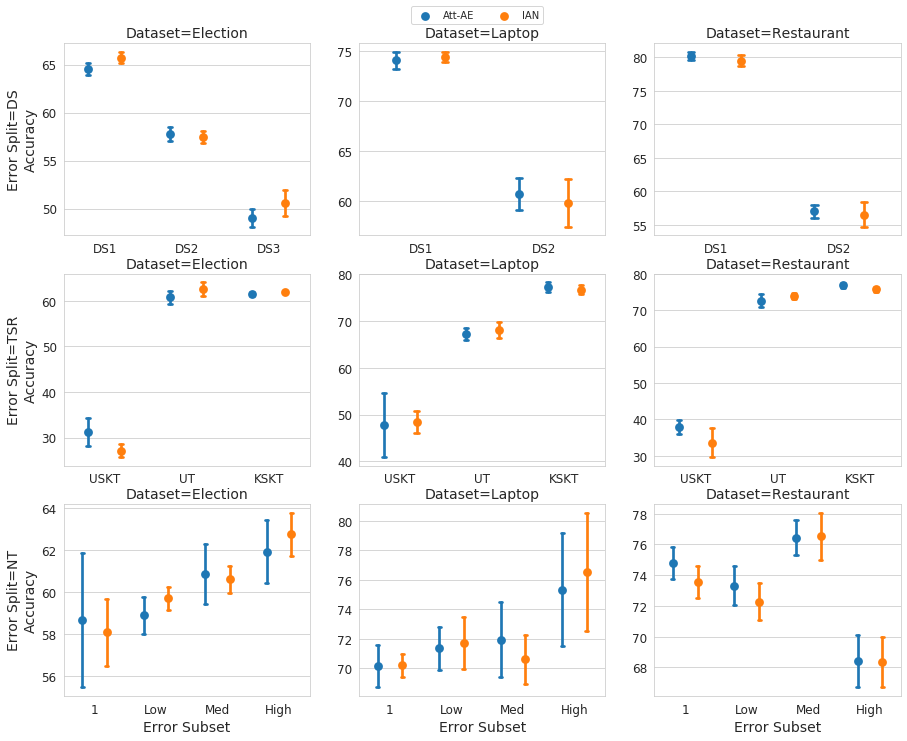

In [ ]:
from target_extraction.analysis.util import plot_error_subsets
_, _ = plot_error_subsets(subset_position_plotting_validation_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          legend_bbox_to_anchor=(0.21, 1.1))

Test:

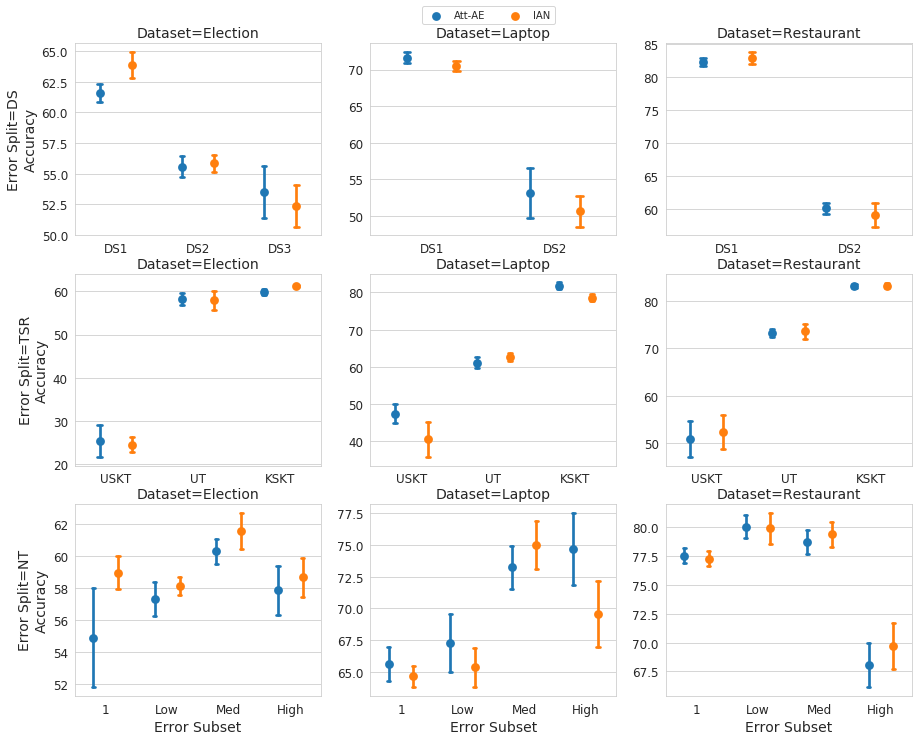

In [ ]:
_, _ = plot_error_subsets(subset_position_plotting_test_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          legend_bbox_to_anchor=(0.21, 1.1))

Validation (performance difference between position and their respective baseline models):

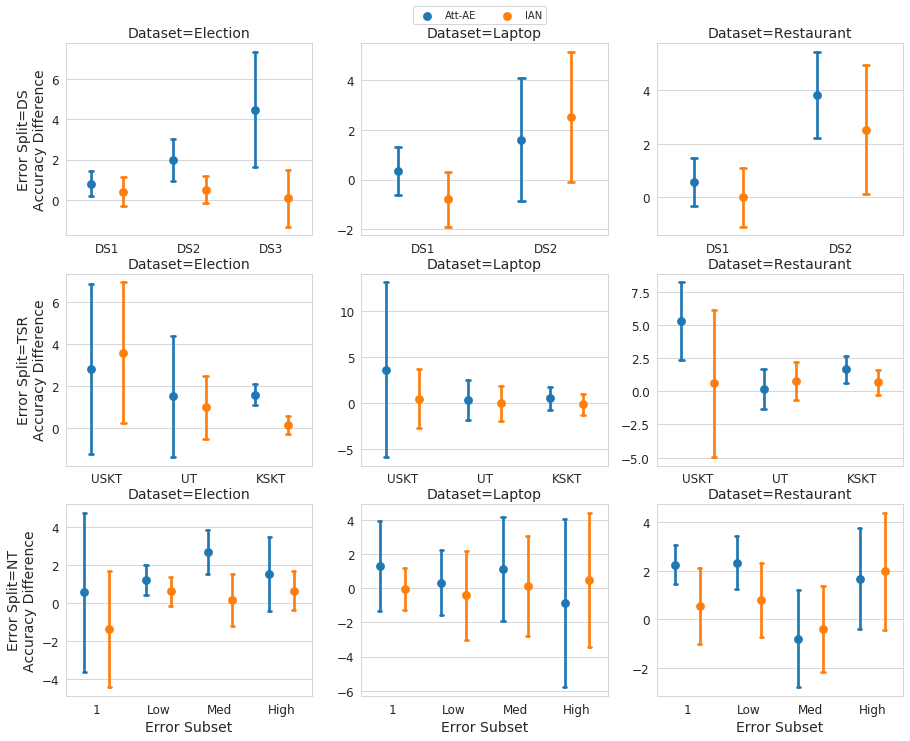

In [ ]:
subset_baseline_plotting_results = filter_df(subset_plotting_results, baseline_column_values)
metric_indexs = ['run number', 'Model', 'Dataset', 'Data Split', 'Error Split', 'Error Subset']
subset_compare_plotting_results = compare_results(subset_position_plotting_results, 
                                                  subset_baseline_plotting_results, 
                                                  metric_indexs, 'Accuracy')
subset_compare_plotting_results['Accuracy Difference'] = subset_compare_plotting_results['Accuracy']
subset_compare_plotting_validation_results = subset_compare_plotting_results[subset_compare_plotting_results['Data Split']=='Validation']
subset_compare_plotting_test_results = subset_compare_plotting_results[subset_compare_plotting_results['Data Split']=='Test']
_, _ = plot_error_subsets(subset_compare_plotting_validation_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy Difference', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          legend_bbox_to_anchor=(0.21, 1.1))

Test:

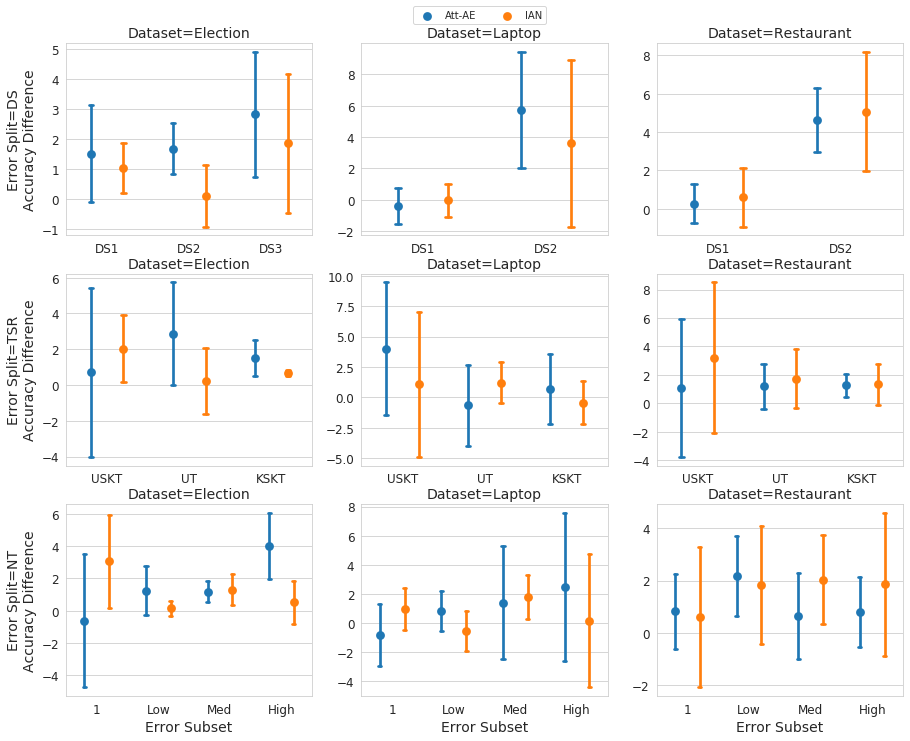

In [ ]:
_, _ = plot_error_subsets(subset_compare_plotting_test_results, 'Dataset', 'Error Split', 
                          'Error Subset', 'Accuracy Difference', df_hue_name='Model',
                          legend_column=1, title_on_every_plot=True,
                          legend_bbox_to_anchor=(0.21, 1.1))

To better visulaise the results below we have a heatmap showing the number of position models which are significantly better than their baseline equiavlent. The test and validation splits appear to have a lot of differences in that the test split has far more statistical significant position models on more subsets than the validation split, therefore we are only going to concentrate on the models that are significant in both splits 

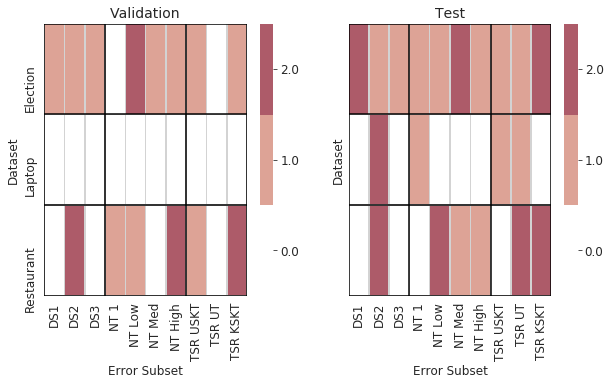

In [ ]:
subset_combined_plotting_results = subset_position_plotting_results.copy(deep=True)
subset_combined_plotting_results['Model'] = subset_combined_plotting_results['Model'].replace(baseline_comparison_models)
subset_combined_plotting_results = pd.concat([subset_combined_plotting_results, 
                                              subset_baseline_plotting_results],
                                             sort=False, ignore_index=True)
error_subsets = ['DS1', 'DS2', 'DS3', 'USKT', 'UT', 'KSKT', '1', 
                 'Low', 'Med', 'High']
p_value_list = []
for split_name in split_names:
  split_df = subset_combined_plotting_results[subset_combined_plotting_results['Data Split']==split_name]
  for position_model_name in position_model_names:
    for error_subset in error_subsets:
      error_subset_split_df = split_df[split_df['Error Subset']==error_subset]
      base_model_name = position_comparison_models[position_model_name]
      p_value_df = metric_p_values(error_subset_split_df, f'{position_model_name}', 
                                   [base_model_name], dataset_names, 
                                   metric_names_assume_normals=[('Accuracy', True)])
      error_split = error_subset_split_df['Error Split'].unique()[0]
      p_value_df['Split'] = split_name
      p_value_df['Error Subset'] = error_subset
      p_value_df['Error Split'] = error_split
      p_value_list.append(p_value_df)
error_subset_p_values = pd.concat(p_value_list)
validation_error_subset_p_values = error_subset_p_values[error_subset_p_values['Split']=='Validation']
test_error_subset_p_values = error_subset_p_values[error_subset_p_values['Split']=='Test']

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axes[0] = create_subset_heatmap(validation_error_subset_p_values, 'P-Value', 
                                p_value_count(0.05), ax=axes[0], 
                                font_label_size=12,
                                vertical_lines_index=[0,3,7,10])
axes[0].set_title('Validation')
axes[1] = create_subset_heatmap(test_error_subset_p_values, 'P-Value', 
                                p_value_count(0.05), ax=axes[1], 
                                font_label_size=12,
                                vertical_lines_index=[0,3,7,10])
_ = axes[1].set_title('Test')

In [ ]:
pd.pivot_table(validation_error_subset_p_values, values='P-Value', columns=['Dataset'], index=['Error Subset', 'Better Model'])

Dataset                       Election    Laptop  Restaurant
Error Subset Better Model                                   
1            Att-AE-Position  0.364462  0.064746    0.000918
             IAN-Position     0.861329  0.542395    0.160289
DS1          Att-AE-Position  0.012575  0.249483    0.118121
             IAN-Position     0.092980  0.975134    0.500000
DS2          Att-AE-Position  0.000109  0.066904    0.000011
             IAN-Position     0.107834  0.071409    0.004209
DS3          Att-AE-Position  0.000279       NaN         NaN
             IAN-Position     0.459631       NaN         NaN
High         Att-AE-Position  0.037332  0.684749    0.020414
             IAN-Position     0.097162  0.408894    0.026028
KSKT         Att-AE-Position  0.000002  0.233467    0.000104
             IAN-Position     0.236099  0.636414    0.032136
Low          Att-AE-Position  0.005756  0.365150    0.000989
             IAN-Position     0.033746  0.674848    0.072789
Med          Att-AE-Position  0.000562  0.243328    0.890067
             IAN-Position     0.372397  0.456742    0.711863
USKT         Att-AE-Position  0.050694  0.130345    0.000081
             IAN-Position     0.002450  0.368360    0.367108
UT           Att-AE-Position  0.107002  0.352227    0.410644
             IAN-Position     0.090618  0.527597    0.084589

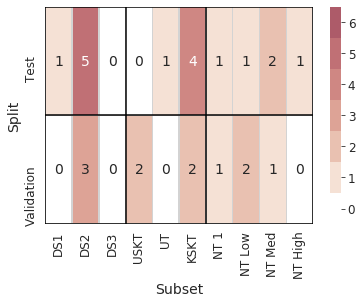

In [ ]:
corrected_subset_split_names = []
corrected_subset_sig_models = []
corrected_subsets = []
for split_name in split_names:
  split_df = error_subset_p_values[error_subset_p_values['Split']==split_name]
  for subset in error_subsets:
    subset_df = split_df[split_df['Error Subset']==subset]
    num_sig_models = find_k_estimator(subset_df['P-Value'], 
                                      alpha=0.05, method='B')
    if subset in ['1', 'Low', 'Med', 'High']:
      subset = f'NT {subset}'
    corrected_subsets.append(subset)
    corrected_subset_sig_models.append(num_sig_models)
    corrected_subset_split_names.append(split_name)
corrected_subset_p_values_df = pd.DataFrame({'Num Sig Models': corrected_subset_sig_models, 
                                             'Subsets': corrected_subsets, 
                                             'Split': corrected_subset_split_names})
h_map_subset_kwargs = {'value_column': 'Num Sig Models', 'pivot_columns': ['Subsets'], 
                       'pivot_indexes': ['Split'], 'x_label': 'Subset', 
                       'y_label': 'Split', 'pivot_table_agg_func': np.sum,
                       'vertical_lines_index': [0,3,6,10], 
                       'horizontal_lines_index': range(3)}
_ = create_p_value_heatmap(corrected_subset_p_values_df, **h_map_subset_kwargs, 
                           value_range=range(7),heatmap_kwargs={'annot': True},
                           column_order=['DS1','DS2','DS3','USKT','UT','KSKT',
                                         'NT 1','NT Low','NT Med','NT High'])

In prior work by [He et al. 2018]() they claimed that their syntax based poisiton weighting model improved the target sentiment relation modelling. Of which we feel that this is best shown through the *DS* subsets and *STAC Multi* metric. However in their paper they showed this through the increase in accuracy over baseline based on the *NT* split, so as the number of targets per sentence increases the performance does not drop. However we have shown in the prior notebook that the *NT* split will not actually show this if you factor in the *DS* subsets. Therefore below we shall show this for the position models. 

Validation:

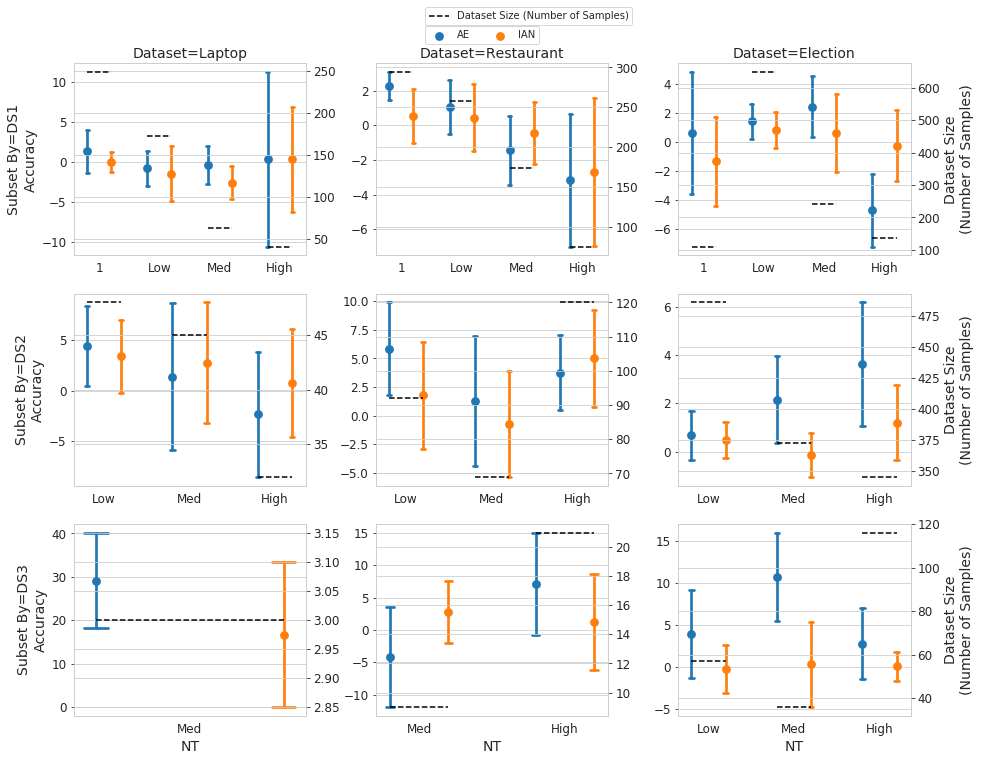

In [ ]:
temp_dfs = pd.read_csv('https://raw.githubusercontent.com/apmoore1/tdsa_comparisons/master/saved_results/position_nt_subset_results.tsv',
                         sep='\t')
temp_dfs = temp_dfs.drop(columns=['Unnamed: 0'])

# Remove all that have zero accuracy
temp_dfs = temp_dfs[temp_dfs['Accuracy']!=0]
position_temp_dfs = temp_dfs[temp_dfs['Position']=='Weighting']
baseline_temp_dfs = temp_dfs[temp_dfs['Position']=='False']
index_columns = ['run number', 'Reduced Error Split', 'NT', 'Subset By', 'Model']
diff_temp_dfs = compare_results(position_temp_dfs, baseline_temp_dfs, index_columns, 'Accuracy')
diff_validation_temp_dfs = diff_temp_dfs[diff_temp_dfs['Split']=='Val']
diff_test_temp_dfs = diff_temp_dfs[diff_temp_dfs['Split']=='Test']

_ = plot_error_subsets(diff_validation_temp_dfs, 'Dataset', 'Subset By', 
                       'NT', 'Accuracy', 'Model', df_dataset_size='Dataset Size',
                       legend_column=1, legend_bbox_to_anchor=(0.21, 1.1))

Test:

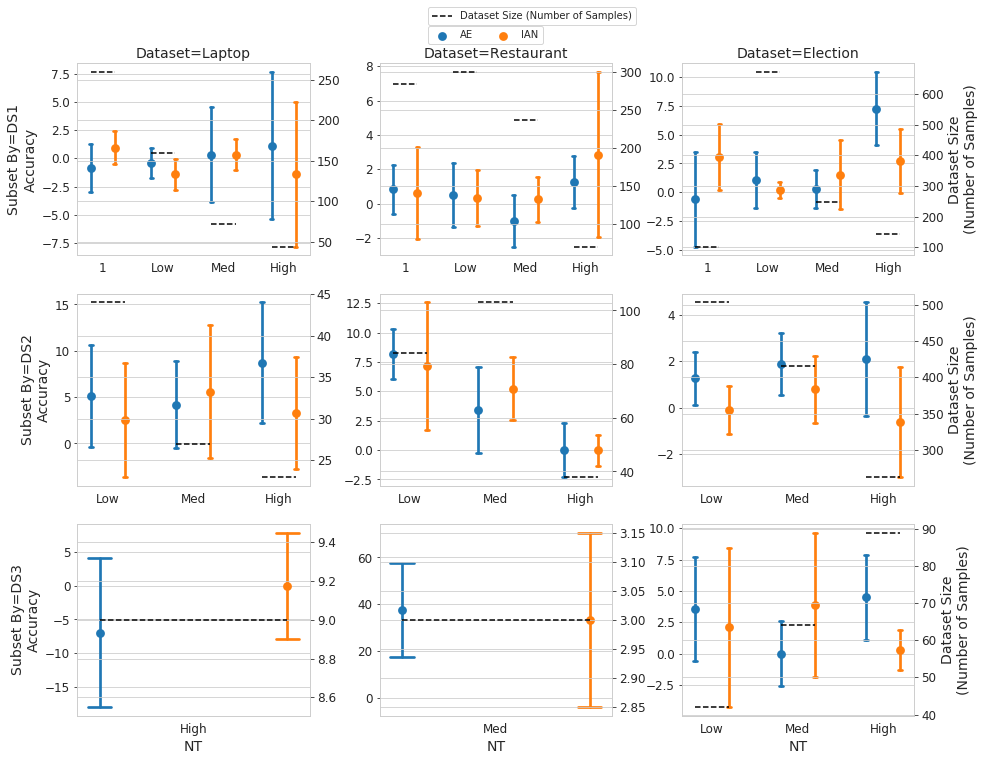

In [ ]:
_ = plot_error_subsets(diff_test_temp_dfs, 'Dataset', 'Subset By', 
                       'NT', 'Accuracy', 'Model', df_dataset_size='Dataset Size',
                       legend_column=1, legend_bbox_to_anchor=(0.21, 1.1))